In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4 as nc
from datetime import datetime
import scipy.io as sio
import datetime
from datetime import datetime, timedelta
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
import pickle
import matplotlib.dates as mdates


import sys
sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules") 
from utils import plot_ellipse, moca, gaussian_vel_reconstruction, espra



#### Drifter Data

In [2]:
drifter_path = '/srv/scratch/z5297792/IN2023/2023_drifters.nc'
drifter_dataset = nc.Dataset(drifter_path, mode='r')

u_drif, v_drif = drifter_dataset['ve'][:].data/100, drifter_dataset['vn'][:].data/100
lon_drif, lat_drif = drifter_dataset['longitude'][:].data, drifter_dataset['latitude'][:].data
tim_drif, ID_drif = drifter_dataset['time'][:].data, drifter_dataset['ID'][:].data
dt_strings = [b''.join(row).decode('utf-8') for row in tim_drif]
tim_drif = [datetime.fromisoformat(s) for s in dt_strings]
df_drifters = pd.DataFrame({'ID': ID_drif.astype(int), 'Lon': lon_drif, 'Lat': lat_drif, 'u': u_drif, 'v': v_drif, 'Time': tim_drif})
df_drifters

,ID,Lon,Lat,u,v,Time
0,1,155.071686,-37.423271,0.336407,-0.524240,2023-10-23 16:00:00
1,1,155.085403,-37.440243,0.342941,-0.514329,2023-10-23 17:00:00
2,1,155.099655,-37.456573,0.356158,-0.494175,2023-10-23 18:00:00
3,1,155.114456,-37.472240,0.367879,-0.471484,2023-10-23 19:00:00
4,1,155.129669,-37.487103,0.357340,-0.426944,2023-10-23 20:00:00
...,...,...,...,...,...,...
32704,19,157.954788,-33.808270,0.788511,-0.257061,2023-12-30 18:00:00
32705,19,157.985443,-33.815174,0.778468,-0.190267,2023-12-30 19:00:00
32706,19,158.015457,-33.820591,0.769020,-0.143037,2023-12-30 20:00:00
32707,19,158.045380,-33.824436,0.766826,-0.095277,2023-12-30 21:00:00


#### Ship Data

In [3]:
sadcp_data = sio.loadmat('/srv/scratch/z5297792/IN2023/sadcp.mat', simplify_cells=True)

z_sadcp = sadcp_data['z_sadcp']
u_sadcp = pd.DataFrame(sadcp_data['u_sadcp'], index=z_sadcp)
v_sadcp = pd.DataFrame(sadcp_data['v_sadcp'], index=z_sadcp)
lat_sadcp = sadcp_data['lat_sadcp']
lon_sadcp = sadcp_data['lon_sadcp']
tim_sadcp = sadcp_data['tim_sadcp']
julian_dates = tim_sadcp
ref_date = datetime(2000, 1, 1, 12)  # Julian day 2451545.0
gregorian_dates = [ref_date + timedelta(days=jd - 2451545.0) for jd in julian_dates]
tim_sadcp = gregorian_dates

depth = 37
df_sadcp = pd.DataFrame({'Lon': lon_sadcp, 'Lat': lat_sadcp, 'u': u_sadcp.loc[depth], 'v': v_sadcp.loc[depth], 'Time': tim_sadcp})
df_sadcp

,Lon,Lat,u,v,Time
0,151.320299,-33.889224,0.005571,-0.115798,2023-10-09 11:56:08.499988
1,151.336628,-33.915619,-0.007718,-0.126222,2023-10-09 12:13:38.666652
2,151.372994,-33.939047,-0.006178,-0.136486,2023-10-09 12:26:08.500002
3,151.426511,-33.973251,-0.040717,-0.105075,2023-10-09 12:43:38.666665
4,151.464043,-33.998656,-0.054494,-0.137621,2023-10-09 12:56:08.749984
...,...,...,...,...,...
2169,152.133657,-33.499170,-0.193570,-1.186649,2023-11-01 03:40:29.666685
2170,152.162703,-33.499744,-0.265587,-1.283703,2023-11-01 03:55:29.333340
2171,152.191377,-33.499695,-0.273816,-1.294686,2023-11-01 04:10:29.666658
2172,152.220223,-33.499658,-0.283102,-1.272112,2023-11-01 04:25:29.333353


,ID,Lon,Lat,u,v,Time
0,NaN,151.320299,-33.889224,0.005571,-0.115798,2023-10-09 11:56:08.499988
1,NaN,151.336628,-33.915619,-0.007718,-0.126222,2023-10-09 12:13:38.666652
2,NaN,151.372994,-33.939047,-0.006178,-0.136486,2023-10-09 12:26:08.500002
3,NaN,151.426511,-33.973251,-0.040717,-0.105075,2023-10-09 12:43:38.666665
4,NaN,151.464043,-33.998656,-0.054494,-0.137621,2023-10-09 12:56:08.749984
...,...,...,...,...,...,...
34878,8.0,163.780426,-29.946438,0.223790,-0.060704,2023-12-30 23:00:00.000000
34879,4.0,162.917786,-38.022373,0.095789,0.021097,2023-12-30 23:00:00.000000
34880,6.0,163.140686,-29.742563,0.579057,-0.107962,2023-12-30 23:00:00.000000
34881,7.0,164.334869,-33.275684,0.171763,-0.353148,2023-12-30 23:00:00.000000


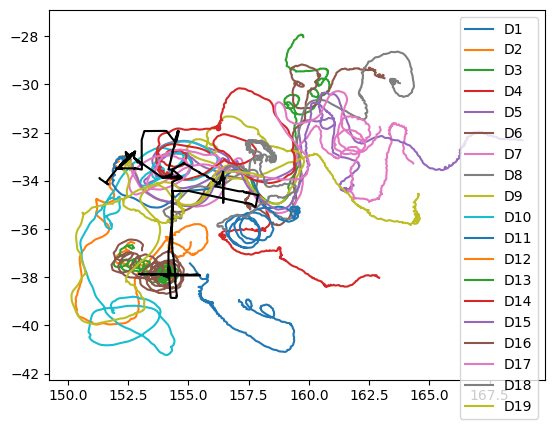

In [4]:
for ID in df_drifters['ID'].unique():
    df_drif = df_drifters[df_drifters['ID']==ID]
    plt.plot(df_drif['Lon'], df_drif['Lat'], label=f'D{ID}')
plt.axis('equal')
plt.legend()
plt.plot(df_sadcp['Lon'], df_sadcp['Lat'], c='k')

df_obs_data = pd.concat([df_drifters, df_sadcp], ignore_index=True, sort=False)
df_obs_data = df_obs_data.sort_values(by='Time').reset_index(drop=True)
df_obs_data

#### Satellite Data

In [5]:
ssh_path = '/srv/scratch/z5297792/IN2023/IMOS_aggregation.nc'
ssh_dataset = nc.Dataset(ssh_path, mode='r')
lon_ssh, lat_ssh = ssh_dataset['LONGITUDE'][:].data, ssh_dataset['LATITUDE'][:].data
lon_ssh, lat_ssh = np.meshgrid(lon_ssh, lat_ssh)
u_ssh, v_ssh = ssh_dataset['UCUR'][:].data, ssh_dataset['VCUR'][:].data # TIME, LATITUDE, LONGITUDE
u_ssh, v_ssh = np.transpose(u_ssh, axes=(2,1,0)), np.transpose(v_ssh, axes=(2,1,0)) # LON, LAT, TIME
# u_ssh, v_ssh = np.where(u_ssh > -4, u_ssh, np.nan), np.where(v_ssh > -4, u_ssh, np.nan)
tim_ssh = ssh_dataset['TIME'][:].data # days since 1985-01-01 00:00:00 UTC

ref_date = pd.Timestamp("1985-01-01 00:00:00")
tim_ssh = ref_date + pd.to_timedelta(tim_ssh, unit="D")

tim_ssh = tim_ssh[tim_ssh <= pd.Timestamp('2023-12-05 06:00:00')] # '2023-12-11 14:00:00'

dic_ssh_data = {}
for t, time in enumerate(tim_ssh):
    ut, vt = u_ssh[:,:,t], v_ssh[:,:,t]
    dic_ssh_data[time] = {'u': ut, 'v': vt}


(np.float64(154.53241883608766), np.float64(-37.9629414382285))

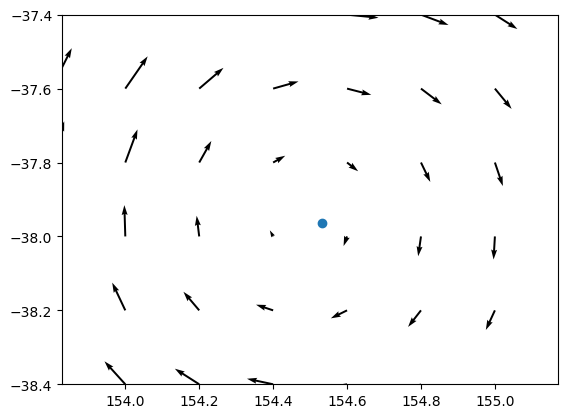

In [6]:
lon_min_CE, lon_max_CE = 154, 155
lat_min_CE, lat_max_CE = -38.4, -37.4

t = 0
ut, vt = u_ssh[:,:,t], v_ssh[:,:,t]
plt.quiver(lon_ssh, lat_ssh, ut.T, vt.T, width=.004, scale=10)

mask = (lon_ssh >= lon_min_CE) & (lon_ssh <= lon_max_CE) & (lat_ssh >= lat_min_CE) & (lat_ssh <= lat_max_CE)
xi, yi, ui, vi = lon_ssh[mask], lat_ssh[mask], ut.T[mask], vt.T[mask]
x0_ssh_start, y0_ssh_start, *_ = espra(xi, yi, ui, vi)
plt.scatter(x0_ssh_start, y0_ssh_start)

plt.axis('equal')
plt.xlim(lon_min_CE, lon_max_CE)
plt.ylim(lat_min_CE, lat_max_CE)
(x0_ssh_start, y0_ssh_start)

,x0,y0,w,Q,Rc,psi0,Time
0,154.513331,-37.967665,-2.447004,"[[-0.5877473529025038, 0.016738686023321403], ...",0.689161,0.537475,2023-10-09 18:00:00
1,154.487559,-37.947104,-2.326234,"[[-0.5449192624557241, 0.02857084453066989], [...",0.649852,0.480928,2023-10-10 18:00:00
2,154.453035,-37.918997,-2.517106,"[[-0.644042680645024, 0.043481836486226014], [...",0.678040,0.522281,2023-10-11 18:00:00
3,154.460335,-37.897166,-2.440685,"[[-0.6072794934030088, 0.037047180869235065], ...",0.692134,0.538232,2023-10-12 18:00:00
4,154.465464,-37.882218,-2.418600,"[[-0.6000208486336674, 0.013704789086651854], ...",0.691007,0.531878,2023-10-13 18:00:00


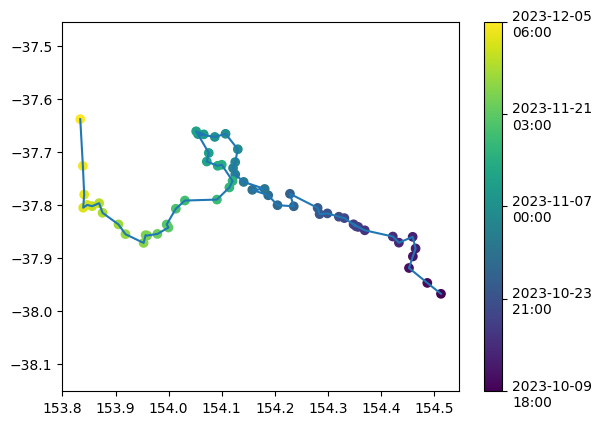

In [7]:
df_ssh_trace = pd.DataFrame(columns=['x0', 'y0', 'w', 'Q', 'Rc', 'psi0', 'Time'])
x0, y0 = (np.float64(154.53241883608766), np.float64(-37.9629414382285)) #start
for t, time in enumerate(tim_ssh):
    mask = np.hypot(x0 - lon_ssh, y0 - lat_ssh) <= .5 #.2
    ut, vt = u_ssh[:,:,t], v_ssh[:,:,t]
    xi, yi, ui, vi = lon_ssh[mask], lat_ssh[mask], ut.T[mask], vt.T[mask]
    x0, y0, w, Q, Rc, psi0 = espra(xi, yi, ui, vi)
    df_ssh_trace.loc[len(df_ssh_trace)] = {'x0': x0, 'y0': y0, 'w': w, 'Q': Q, 'Rc': Rc, 'psi0': psi0, 'Time': time}
# df_ssh_trace = df_ssh_trace.set_index('Time')
plt.plot(df_ssh_trace['x0'], df_ssh_trace['y0'])
times = df_ssh_trace['Time']
norm = plt.Normalize(times.min().timestamp(), times.max().timestamp())
sc = plt.scatter(df_ssh_trace['x0'], df_ssh_trace['y0'], c=times.apply(lambda x: x.timestamp()), cmap='viridis', norm=norm)
cbar = plt.colorbar(sc)
ticks = np.linspace(times.min().timestamp(), times.max().timestamp(), 5)
cbar.set_ticks(ticks)
cbar.set_ticklabels(pd.to_datetime(ticks, unit='s').strftime('%Y-%m-%d\n%H:%M'))
plt.axis('equal')
df_ssh_trace.head()


In [8]:
dic_obs = {}
df_obs_trace = pd.DataFrame(columns=['x0_obs', 'y0_obs', 'w_obs', 'Q_obs', 'Time'])
for k in range(len(df_ssh_trace)):
    df = df_ssh_trace.iloc[k]
    x0_sat, y0_sat, Q_sat, time_sat = df['x0'], df['y0'], df['Q'], df['Time']

    R = np.hypot(df_obs_data['Lon'] - x0_sat, df_obs_data['Lat'] - y0_sat) < 1
    t1 = time_sat - pd.Timedelta(days=1)
    t2 = time_sat + pd.Timedelta(days=1)

    local_obs_data = df_obs_data[(R) & (df_obs_data['Time'] >= t1) & (df_obs_data['Time'] <= t2)]
    if not local_obs_data.empty:
        xi, yi = local_obs_data['Lon'], local_obs_data['Lat']
        ui, vi = local_obs_data['u'], local_obs_data['v']
        time, ID = local_obs_data['Time'], local_obs_data['ID']
        dic_obs[time_sat] = {'xi': xi, 'yi': yi, 'ui': ui, 'vi': vi, 'ID': ID, 'Time': time}

        x0_obs, y0_obs, w_obs, Q_obs, Rc_obs, psi0_obs = espra(xi, yi, ui, vi)
        
        df_obs_trace.loc[len(df_obs_trace)] = {'x0_obs': x0_obs, 'y0_obs': y0_obs, 'w_obs': w_obs, 'Q_obs': Q_obs, 'Rc_obs': Rc_obs, 'psi0': psi0_obs, 'Time': time_sat}
              
df_obs_trace.head()

,x0_obs,y0_obs,w_obs,Q_obs,Time
0,156.358787,-41.755676,1.053795,"[[0.48317619391849176, 0.19908680586678149], [...",2023-10-16 18:00:00
1,154.348506,-37.825435,-2.806474,"[[-1.0944375868673506, -0.08600359191304163], ...",2023-10-17 18:00:00
2,154.302143,-37.958579,-1.951020,"[[-0.5660718126547758, -0.05759633613764082], ...",2023-10-18 18:00:00
3,154.353122,-37.970010,-1.951376,"[[-0.4955986637128211, 0.005022807944589386], ...",2023-10-19 18:00:00
4,154.319285,-37.902019,-2.997401,"[[-0.43356103306321636, 0.09213312682510376], ...",2023-10-20 18:00:00


In [9]:
df_trace = pd.merge(df_ssh_trace, df_obs_trace, on='Time', how='outer')
mask = np.sign(df_trace['w']) == np.sign(df_trace['w_obs']) # erase conflicting cyclonicities
cols_obs = [col for col in df_trace.columns if 'obs' in col]
df_trace.loc[~mask, cols_obs] = np.nan
mask = np.hypot(df_trace['x0'] - df_trace['x0_obs'], # erase large errors
                df_trace['y0'] - df_trace['y0_obs']) < 0.5
cols_obs = [col for col in df_trace.columns if 'obs' in col]
df_trace.loc[~mask, cols_obs] = np.nan
df_trace.head()

,x0,y0,w,Q,Rc,psi0,Time,x0_obs,y0_obs,w_obs,Q_obs
0,154.513331,-37.967665,-2.447004,"[[-0.5877473529025038, 0.016738686023321403], ...",0.689161,0.537475,2023-10-09 18:00:00,NaN,NaN,NaN,NaN
1,154.487559,-37.947104,-2.326234,"[[-0.5449192624557241, 0.02857084453066989], [...",0.649852,0.480928,2023-10-10 18:00:00,NaN,NaN,NaN,NaN
2,154.453035,-37.918997,-2.517106,"[[-0.644042680645024, 0.043481836486226014], [...",0.678040,0.522281,2023-10-11 18:00:00,NaN,NaN,NaN,NaN
3,154.460335,-37.897166,-2.440685,"[[-0.6072794934030088, 0.037047180869235065], ...",0.692134,0.538232,2023-10-12 18:00:00,NaN,NaN,NaN,NaN
4,154.465464,-37.882218,-2.418600,"[[-0.6000208486336674, 0.013704789086651854], ...",0.691007,0.531878,2023-10-13 18:00:00,NaN,NaN,NaN,NaN


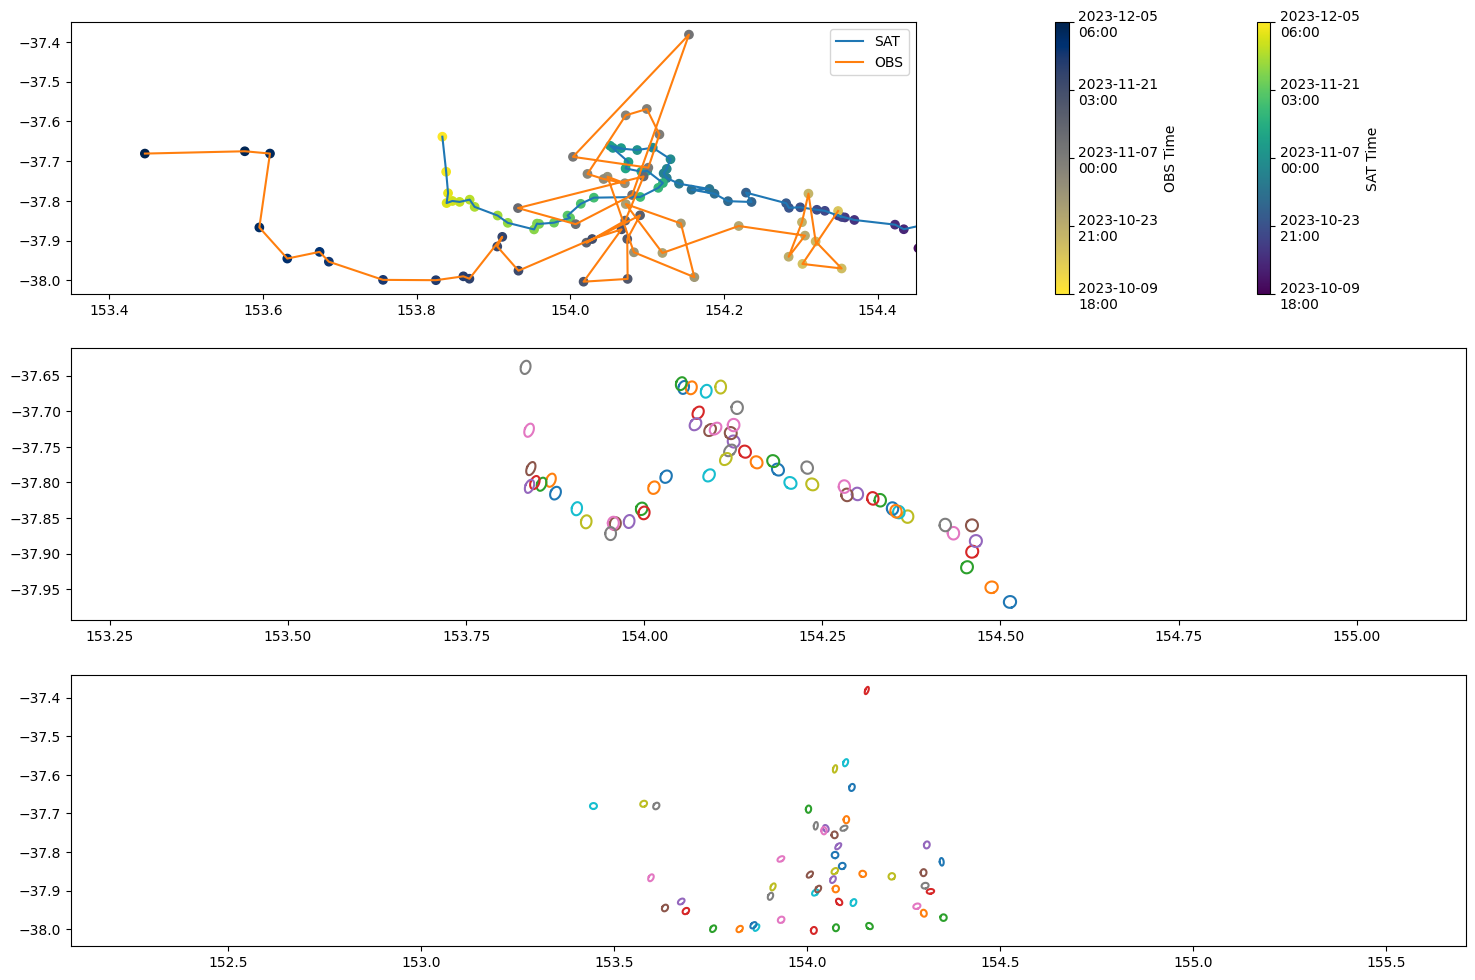

In [10]:
fig, axs = plt.subplots(3, 1, figsize=(18, 12))

# Plot SAT path
axs[0].plot(df_trace['x0'], df_trace['y0'], label='SAT')
for x0, y0, Q in zip(df_trace['x0'], df_trace['y0'], df_trace['Q']):
    if not np.any(np.isnan(Q)):
        x_ell, y_ell = plot_ellipse(Q, (x0, y0), scale=0.01)
        axs[1].plot(x_ell, y_ell)

# axs[1].set_xlim(153.4, 154.4)
axs[1].axis('equal')

# Plot OBS path
axs[0].plot(df_trace['x0_obs'], df_trace['y0_obs'], label='OBS')
for x0, y0, Q in zip(df_trace['x0_obs'], df_trace['y0_obs'], df_trace['Q_obs']):
    if not np.any(np.isnan(Q)):
        x_ell, y_ell = plot_ellipse(Q, (x0, y0), scale=0.01)
        axs[2].plot(x_ell, y_ell)

# axs[2].set_xlim(153.4, 154.4)
axs[2].axis('equal')

# Time values
times = df_trace['Time']
timestamps = times.apply(lambda x: x.timestamp())

# SAT scatter + colorbar
norm_sat = plt.Normalize(timestamps.min(), timestamps.max())
sc1 = axs[0].scatter(df_trace['x0'], df_trace['y0'], c=timestamps, cmap='viridis', norm=norm_sat)
cbar1 = fig.colorbar(sc1, ax=axs[0], location='right', pad=0.02)
ticks = np.linspace(timestamps.min(), timestamps.max(), 5)
cbar1.set_ticks(ticks)
cbar1.set_ticklabels(pd.to_datetime(ticks, unit='s').strftime('%Y-%m-%d\n%H:%M'))
cbar1.set_label('SAT Time')

# OBS scatter + separate colorbar
sc2 = axs[0].scatter(df_trace['x0_obs'], df_trace['y0_obs'], c=timestamps, cmap='cividis_r', norm=norm_sat)
cbar2 = fig.colorbar(sc2, ax=axs[0], location='right', pad=0.12)
cbar2.set_ticks(ticks)
cbar2.set_ticklabels(pd.to_datetime(ticks, unit='s').strftime('%Y-%m-%d\n%H:%M'))
cbar2.set_label('OBS Time')

axs[0].set_xlim(153.35, 154.45)
axs[0].legend()


### Hourly Analysis

In [11]:
df = df_ssh_trace.copy()
df['Time'] = pd.to_datetime(df['Time'])
df = df.set_index('Time')
hourly_index = pd.date_range(df.index.min(), df.index.max(), freq='1h') 
df_interp = df[['x0', 'y0']].reindex(hourly_index).interpolate()
df_full = df.reindex(hourly_index)
df_full[['x0', 'y0']] = df_interp[['x0', 'y0']]
df_ssh_trace_hrly = df_full.reset_index().rename(columns={'index': 'Time'})
df_ssh_trace_hrly = df_ssh_trace_hrly[[col for col in df_ssh_trace_hrly.columns if col != 'Time'] + ['Time']]
df_ssh_trace_hrly


,x0,y0,w,Q,Rc,psi0,Time
0,154.513331,-37.967665,-2.447004,"[[-0.5877473529025038, 0.016738686023321403], ...",0.689161,0.537475,2023-10-09 18:00:00
1,154.512257,-37.966808,NaN,NaN,NaN,NaN,2023-10-09 19:00:00
2,154.511183,-37.965951,NaN,NaN,NaN,NaN,2023-10-09 20:00:00
3,154.510109,-37.965095,NaN,NaN,NaN,NaN,2023-10-09 21:00:00
4,154.509036,-37.964238,NaN,NaN,NaN,NaN,2023-10-09 22:00:00
...,...,...,...,...,...,...,...
1352,153.834314,-37.653143,NaN,NaN,NaN,NaN,2023-12-05 02:00:00
1353,153.834108,-37.649467,NaN,NaN,NaN,NaN,2023-12-05 03:00:00
1354,153.833902,-37.645791,NaN,NaN,NaN,NaN,2023-12-05 04:00:00
1355,153.833695,-37.642114,NaN,NaN,NaN,NaN,2023-12-05 05:00:00


In [12]:
dic_obs_hrly = {}
df_obs_trace_hrly = pd.DataFrame(columns=['x0_obs', 'y0_obs', 'Q_obs', 'w_obs', 'Rc_obs', 'psi0_obs', 'Time'])
for k in range(len(df_ssh_trace_hrly)):
    df = df_ssh_trace_hrly.iloc[k]
    x0_sat, y0_sat, Q_sat, time_sat = df['x0'], df['y0'], df['Q'], df['Time']

    R = np.hypot(df_obs_data['Lon'] - x0_sat, df_obs_data['Lat'] - y0_sat) < 1
    t1 = time_sat - pd.Timedelta(days=1)
    t2 = time_sat + pd.Timedelta(days=1)

    local_obs_data = df_obs_data[(R) & (df_obs_data['Time'] >= t1) & (df_obs_data['Time'] <= t2)]
    if not local_obs_data.empty:
        xi, yi = local_obs_data['Lon'], local_obs_data['Lat']
        ui, vi = local_obs_data['u'], local_obs_data['v']
        time, ID = local_obs_data['Time'], local_obs_data['ID']

        mask = ((ID == 12) | (ID == 13) | (ID == 16) | np.isnan(ID)) # Just three drifters + SADCP data
        xi = xi[mask]
        yi = yi[mask]
        ui = ui[mask]
        vi = vi[mask]
        ID = ID[mask]
        time = time[mask]

        dic_obs_hrly[time_sat] = {'xi': xi, 'yi': yi, 'ui': ui, 'vi': vi, 'ID': ID, 'Time': time}

        x0_obs, y0_obs, w_obs, Q_obs, Rc_obs, psi0_obs = espra(xi, yi, ui, vi)
        
        df_obs_trace_hrly.loc[len(df_obs_trace_hrly)] = {'x0_obs': x0_obs, 'y0_obs': y0_obs, 'Q_obs': Q_obs, 'w_obs': w_obs, 'Rc_obs': Rc_obs, 'psi0_obs': psi0_obs, 'Time': time_sat}
              
df_obs_trace_hrly.head()


,x0_obs,y0_obs,Q_obs,w_obs,Rc_obs,psi0_obs,Time
0,154.120627,-34.914939,"[[1267.1701141176454, 143.29588974455422], [14...",2566.970965,5.460979,-30.044970,2023-10-16 10:00:00
1,154.129529,-34.993602,"[[220.51201751530593, 24.956225398414603], [24...",446.908153,3.833975,-14.936216,2023-10-16 11:00:00
2,101.824340,534.305250,"[[8.168298986695023, 0.7511400735707725], [0.7...",16.475491,9.303486,-63.228899,2023-10-16 12:00:00
3,141.412778,215.136948,"[[2.8614924874034737, 0.14701654081580587], [0...",5.739700,7.120286,-51.169154,2023-10-16 13:00:00
4,156.686838,118.790430,"[[0.7669036779300251, -0.011287898137438714], ...",1.536668,12.825840,-6472.241454,2023-10-16 14:00:00


In [13]:
df_trace_hrly = pd.merge(df_ssh_trace_hrly, df_obs_trace_hrly, on='Time', how='outer')

# Erase conflicting cyclonicities
conflict = (
    df_trace_hrly['w'].notna() &
    df_trace_hrly['w_obs'].notna() &
    (np.sign(df_trace_hrly['w']) != np.sign(df_trace_hrly['w_obs']))
)
cols_obs = [col for col in df_trace_hrly.columns if 'obs' in col]
df_trace_hrly.loc[conflict, cols_obs] = np.nan

# Erase large errors based on the hypotenuse distance
mask = np.hypot(df_trace_hrly['x0'] - df_trace_hrly['x0_obs'],
                df_trace_hrly['y0'] - df_trace_hrly['y0_obs']) < 0.5
cols_obs = [col for col in df_trace_hrly.columns if 'obs' in col]
df_trace_hrly.loc[~mask, cols_obs] = np.nan

# Additionally, if 'w_obs' is less than -5, set 'obs' columns to NaN
mask_w_obs = df_trace_hrly['w_obs'] <= -4.5
cols_obs = [col for col in df_trace_hrly.columns if 'obs' in col]
df_trace_hrly.loc[mask_w_obs, cols_obs] = np.nan

# Keep only rows where 'x0_obs' is not NaN and reset the index
df_trace_hrly = df_trace_hrly[df_trace_hrly['x0_obs'].notna()]
df_trace_hrly = df_trace_hrly.reset_index(drop=True)
df_trace_hrly


,x0,y0,w,Q,Rc,psi0,Time,x0_obs,y0_obs,Q_obs,w_obs,Rc_obs,psi0_obs
0,154.369668,-37.847939,-2.722333,"[[-0.7333256020628011, 0.00994353496575264], [...",0.676604,0.529453,2023-10-17 18:00:00,154.348506,-37.825435,"[[-1.0944375868673506, -0.08600359191304163], ...",-2.806474,0.530589,0.411660
1,154.369155,-37.847674,NaN,NaN,NaN,NaN,2023-10-17 19:00:00,154.321035,-37.836806,"[[-0.8411160301245687, -0.06246510933255186], ...",-2.277430,0.526866,0.414340
2,154.368642,-37.847410,NaN,NaN,NaN,NaN,2023-10-17 20:00:00,154.315800,-37.833837,"[[-0.8091982135321757, -0.060473981849486935],...",-2.217344,0.536204,0.427822
3,154.368129,-37.847145,NaN,NaN,NaN,NaN,2023-10-17 21:00:00,154.312867,-37.830457,"[[-0.7935768571234185, -0.05989028419466924], ...",-2.189608,0.538815,0.431737
4,154.367615,-37.846881,NaN,NaN,NaN,NaN,2023-10-17 22:00:00,154.317559,-37.822668,"[[-0.8284670993897083, -0.06346555416666821], ...",-2.266267,0.543179,0.436615
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1160,153.834314,-37.653143,NaN,NaN,NaN,NaN,2023-12-05 02:00:00,153.479102,-37.692951,"[[-0.49513730689255275, 0.0001408370391555682]...",-2.290758,0.691336,0.521158
1161,153.834108,-37.649467,NaN,NaN,NaN,NaN,2023-12-05 03:00:00,153.472293,-37.690667,"[[-0.4852210937277177, 0.0001915205025619145],...",-2.282821,0.631922,0.444160
1162,153.833902,-37.645791,NaN,NaN,NaN,NaN,2023-12-05 04:00:00,153.465094,-37.687700,"[[-0.47706896106037133, 0.0013224202865010145]...",-2.257916,0.582576,0.386439
1163,153.833695,-37.642114,NaN,NaN,NaN,NaN,2023-12-05 05:00:00,153.456370,-37.684327,"[[-0.46918454908297746, 0.005135772781083276],...",-2.223501,0.542599,0.344542


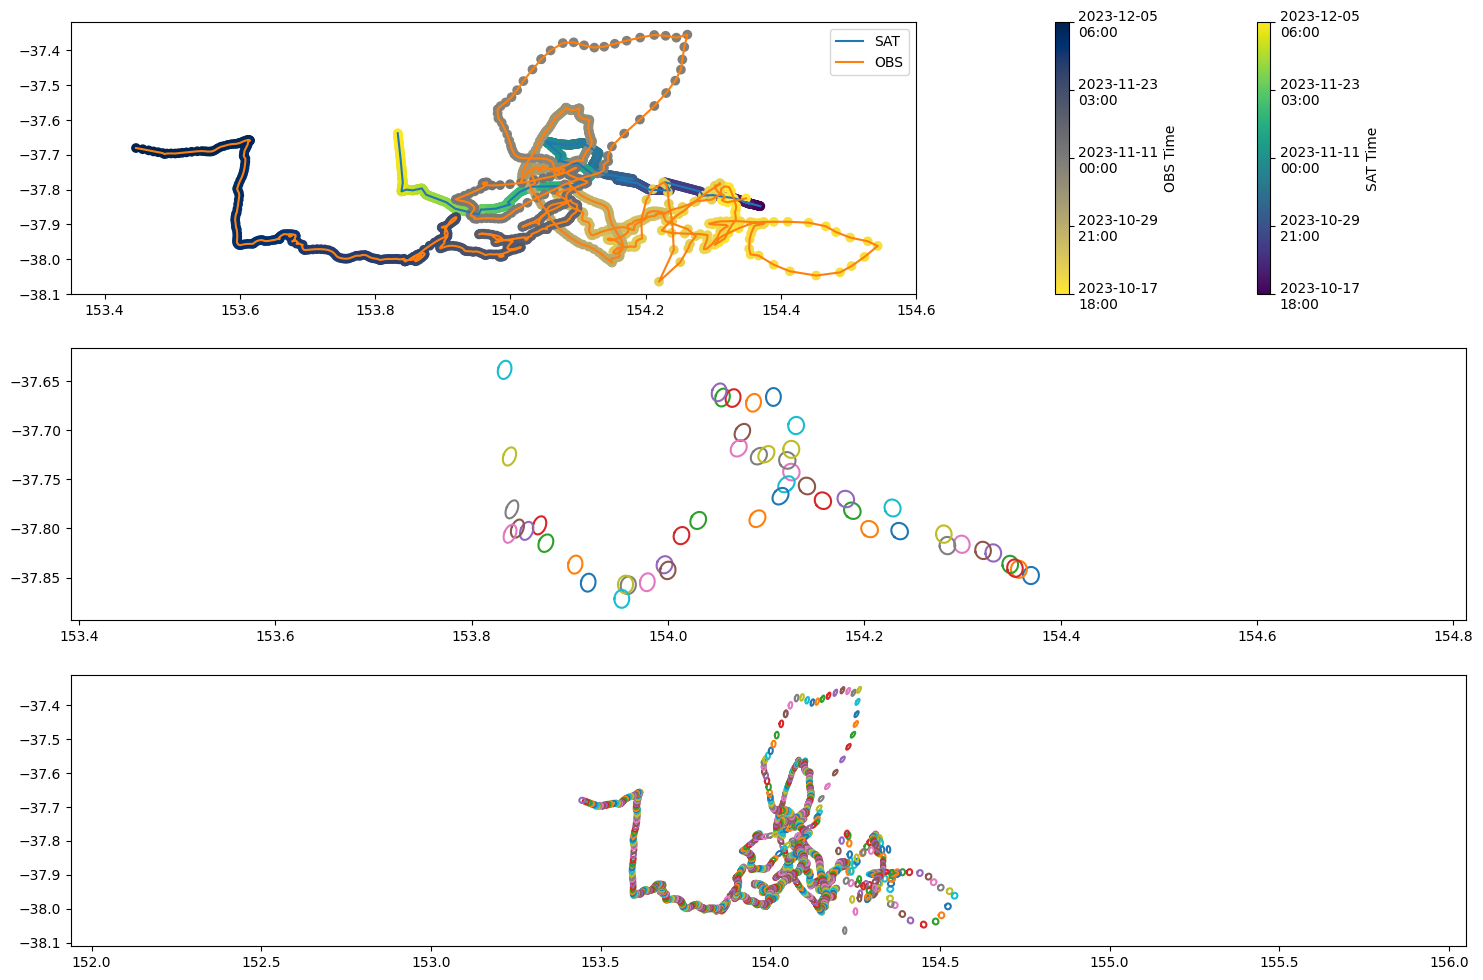

In [14]:
fig, axs = plt.subplots(3, 1, figsize=(18, 12))

# Plot SAT path
axs[0].plot(df_trace_hrly['x0'], df_trace_hrly['y0'], label='SAT')
for x0, y0, Q in zip(df_trace_hrly['x0'], df_trace_hrly['y0'], df_trace_hrly['Q']):
    if not np.any(np.isnan(Q)):
        x_ell, y_ell = plot_ellipse(Q, (x0, y0), scale=0.01)
        axs[1].plot(x_ell, y_ell)

# axs[1].set_xlim(153.4, 154.4)
axs[1].axis('equal')

# Plot OBS path
axs[0].plot(df_trace_hrly['x0_obs'], df_trace_hrly['y0_obs'], label='OBS')
for x0, y0, Q in zip(df_trace_hrly['x0_obs'], df_trace_hrly['y0_obs'], df_trace_hrly['Q_obs']):
    if not np.any(np.isnan(Q)):
        x_ell, y_ell = plot_ellipse(Q, (x0, y0), scale=0.01)
        axs[2].plot(x_ell, y_ell)

# axs[2].set_xlim(153.4, 154.4)
axs[2].axis('equal')

# Time values
times = df_trace_hrly['Time']
timestamps = times.apply(lambda x: x.timestamp())

# SAT scatter + colorbar
norm_sat = plt.Normalize(timestamps.min(), timestamps.max())
sc1 = axs[0].scatter(df_trace_hrly['x0'], df_trace_hrly['y0'], c=timestamps, cmap='viridis', norm=norm_sat)
cbar1 = fig.colorbar(sc1, ax=axs[0], location='right', pad=0.02)
ticks = np.linspace(timestamps.min(), timestamps.max(), 5)
cbar1.set_ticks(ticks)
cbar1.set_ticklabels(pd.to_datetime(ticks, unit='s').strftime('%Y-%m-%d\n%H:%M'))
cbar1.set_label('SAT Time')

# OBS scatter + separate colorbar
sc2 = axs[0].scatter(df_trace_hrly['x0_obs'], df_trace_hrly['y0_obs'], c=timestamps, cmap='cividis_r', norm=norm_sat)
cbar2 = fig.colorbar(sc2, ax=axs[0], location='right', pad=0.12)
cbar2.set_ticks(ticks)
cbar2.set_ticklabels(pd.to_datetime(ticks, unit='s').strftime('%Y-%m-%d\n%H:%M'))
cbar2.set_label('OBS Time')

axs[0].set_xlim(153.35, 154.6)
axs[0].legend()


In [15]:
dff = df_trace_hrly.copy()
tim_ssh_new = dff[dff['w'].notna()]['Time']

def get_closest_time_info(row):
    time = row['Time']
    closest_time = min(tim_ssh_new, key=lambda t: abs(t - time))
    error_hours = abs((closest_time - time).total_seconds()) / 3600
    return pd.Series({'Closest SAT Time': closest_time, 'SAT Time Difference': error_hours})

df_times = dff.apply(get_closest_time_info, axis=1)
df_times = pd.concat([dff, df_times], axis=1)
df_times


,x0,y0,w,Q,Rc,psi0,Time,x0_obs,y0_obs,Q_obs,w_obs,Rc_obs,psi0_obs,Closest SAT Time,SAT Time Difference
0,154.369668,-37.847939,-2.722333,"[[-0.7333256020628011, 0.00994353496575264], [...",0.676604,0.529453,2023-10-17 18:00:00,154.348506,-37.825435,"[[-1.0944375868673506, -0.08600359191304163], ...",-2.806474,0.530589,0.411660,2023-10-17 18:00:00,0.0
1,154.369155,-37.847674,NaN,NaN,NaN,NaN,2023-10-17 19:00:00,154.321035,-37.836806,"[[-0.8411160301245687, -0.06246510933255186], ...",-2.277430,0.526866,0.414340,2023-10-17 18:00:00,1.0
2,154.368642,-37.847410,NaN,NaN,NaN,NaN,2023-10-17 20:00:00,154.315800,-37.833837,"[[-0.8091982135321757, -0.060473981849486935],...",-2.217344,0.536204,0.427822,2023-10-17 18:00:00,2.0
3,154.368129,-37.847145,NaN,NaN,NaN,NaN,2023-10-17 21:00:00,154.312867,-37.830457,"[[-0.7935768571234185, -0.05989028419466924], ...",-2.189608,0.538815,0.431737,2023-10-17 18:00:00,3.0
4,154.367615,-37.846881,NaN,NaN,NaN,NaN,2023-10-17 22:00:00,154.317559,-37.822668,"[[-0.8284670993897083, -0.06346555416666821], ...",-2.266267,0.543179,0.436615,2023-10-17 18:00:00,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1160,153.834314,-37.653143,NaN,NaN,NaN,NaN,2023-12-05 02:00:00,153.479102,-37.692951,"[[-0.49513730689255275, 0.0001408370391555682]...",-2.290758,0.691336,0.521158,2023-12-05 06:00:00,4.0
1161,153.834108,-37.649467,NaN,NaN,NaN,NaN,2023-12-05 03:00:00,153.472293,-37.690667,"[[-0.4852210937277177, 0.0001915205025619145],...",-2.282821,0.631922,0.444160,2023-12-05 06:00:00,3.0
1162,153.833902,-37.645791,NaN,NaN,NaN,NaN,2023-12-05 04:00:00,153.465094,-37.687700,"[[-0.47706896106037133, 0.0013224202865010145]...",-2.257916,0.582576,0.386439,2023-12-05 06:00:00,2.0
1163,153.833695,-37.642114,NaN,NaN,NaN,NaN,2023-12-05 05:00:00,153.456370,-37.684327,"[[-0.46918454908297746, 0.005135772781083276],...",-2.223501,0.542599,0.344542,2023-12-05 06:00:00,1.0


In [16]:
def plotter(time):
    plt.figure()

    df = df_trace_hrly[df_trace_hrly['Time']==time]
    
    x0, y0, w, Q, Rc, psi0, time, x0_obs, y0_obs, w_obs, Q_obs, Rc_obs, psi0_obs = (
        df['x0'].iloc[0],
        df['y0'].iloc[0],
        df['w'].iloc[0],
        df['Q'].iloc[0],
        df['Rc'].iloc[0],
        df['psi0'].iloc[0],
        df['Time'].iloc[0],
        df['x0_obs'].iloc[0],
        df['y0_obs'].iloc[0],
        df['w_obs'].iloc[0],
        df['Q_obs'].iloc[0],
        df['Rc_obs'].iloc[0],
        df['psi0_obs'].iloc[0],
    )

    tim_ssh_new = df_trace_hrly[df_trace_hrly['w'].notna()]['Time']
    closest_time = min(tim_ssh_new, key=lambda t: abs(t - time))
    
    error_hours = abs((closest_time - time).total_seconds()) / 3600
    plt.title(f'{time}\nSatellite Difference {error_hours} Hours')
    
    ut, vt = dic_ssh_data[closest_time]['u'], dic_ssh_data[closest_time]['v']
    plt.quiver(lon_ssh, lat_ssh, ut.T, vt.T, width=0.003, scale=15)
    
    plt.scatter(x0, y0, marker='x', label='SAT', color='b', zorder=5)
    if not np.any(np.isnan(Q)):
        x_ell, y_ell = plot_ellipse(Q, center=(x0, y0), scale=1)
        plt.plot(x_ell, y_ell, color='b', zorder=2)
    else:
        df = df_trace_hrly[df_trace_hrly['Time']==closest_time]
        x0_sat_closest, y0_sat_closest, Q_sat_closest = df['x0'], df['y0'], df['Q'].iloc[0]
        x_ell, y_ell = plot_ellipse(Q_sat_closest, center=(x0_sat_closest, y0_sat_closest), scale=1)
        plt.plot(x_ell, y_ell, color='b', zorder=2)
        
    plt.scatter(x0_obs, y0_obs, marker='x', label='OBS', color='m', zorder=6)
    if not np.any(np.isnan(Q_obs)):
        x_ell, y_ell = plot_ellipse(Q_obs, center=(x0_obs, y0_obs), scale=1)
        plt.plot(x_ell, y_ell, color='m', zorder=6)


    xi, yi, ID = dic_obs_hrly[time]['xi'], dic_obs_hrly[time]['yi'], dic_obs_hrly[time]['ID']

    xi_ship, yi_ship = xi[np.isnan(ID)], yi[np.isnan(ID)]
    if len(xi_ship) > 0:
        plt.scatter(xi_ship, yi_ship, marker='x', color='limegreen', s=5, label='Ship Data', zorder=3)

    xi_drift, yi_drift = xi[~np.isnan(ID)], yi[~np.isnan(ID)]
    if len(xi_drift) > 0:
        plt.scatter(xi_drift, yi_drift, marker='x', color='g', s=5, label='Drifter Data', zorder=3)
    
    plt.legend(loc='lower right')
    plt.axis('equal')
    plt.xlim(lon_min_CE-2, lon_max_CE+2)
    plt.ylim(lat_min_CE-2, lat_max_CE+2)
    
# for t in np.round(np.linspace(0, len(df_paper_plots) - 1, 50)).astype(int):
#     time = df_paper_plots.loc[t]['Time']
#     plotter(time)


In [17]:
df_trace_hrly.to_pickle("Drifter_plot_data/df_trace_hrly.pkl")
with open("Drifter_plot_data/dic_obs_hrly.pkl", "wb") as f:
    pickle.dump(dic_obs_hrly, f)
with open("Drifter_plot_data/dic_ssh_data.pkl", "wb") as f:
    pickle.dump(dic_ssh_data, f)
    

In [18]:
dff = df_trace_hrly.copy()
tim_ssh_new = dff[dff['w'].notna()]['Time']

def get_closest_time_info(row):
    time = row['Time']
    closest_time = min(tim_ssh_new, key=lambda t: abs(t - time))
    error_hours = abs((closest_time - time).total_seconds()) / 3600
    return pd.Series({'Closest SAT Time': closest_time, 'SAT Time Difference': error_hours})

df_times = dff.apply(get_closest_time_info, axis=1)
df_times = pd.concat([dff, df_times], axis=1)
df_times.head()

,x0,y0,w,Q,Rc,psi0,Time,x0_obs,y0_obs,Q_obs,w_obs,Rc_obs,psi0_obs,Closest SAT Time,SAT Time Difference
0,154.369668,-37.847939,-2.722333,"[[-0.7333256020628011, 0.00994353496575264], [...",0.676604,0.529453,2023-10-17 18:00:00,154.348506,-37.825435,"[[-1.0944375868673506, -0.08600359191304163], ...",-2.806474,0.530589,0.411660,2023-10-17 18:00:00,0.0
1,154.369155,-37.847674,NaN,NaN,NaN,NaN,2023-10-17 19:00:00,154.321035,-37.836806,"[[-0.8411160301245687, -0.06246510933255186], ...",-2.277430,0.526866,0.414340,2023-10-17 18:00:00,1.0
2,154.368642,-37.847410,NaN,NaN,NaN,NaN,2023-10-17 20:00:00,154.315800,-37.833837,"[[-0.8091982135321757, -0.060473981849486935],...",-2.217344,0.536204,0.427822,2023-10-17 18:00:00,2.0
3,154.368129,-37.847145,NaN,NaN,NaN,NaN,2023-10-17 21:00:00,154.312867,-37.830457,"[[-0.7935768571234185, -0.05989028419466924], ...",-2.189608,0.538815,0.431737,2023-10-17 18:00:00,3.0
4,154.367615,-37.846881,NaN,NaN,NaN,NaN,2023-10-17 22:00:00,154.317559,-37.822668,"[[-0.8284670993897083, -0.06346555416666821], ...",-2.266267,0.543179,0.436615,2023-10-17 18:00:00,4.0


In [19]:
df_paper_plots = df_times[df_times['SAT Time Difference'] <= 3]
df_paper_plots = df_paper_plots.reset_index(drop=True)
df_paper_plots

,x0,y0,w,Q,Rc,psi0,Time,x0_obs,y0_obs,Q_obs,w_obs,Rc_obs,psi0_obs,Closest SAT Time,SAT Time Difference
0,154.369668,-37.847939,-2.722333,"[[-0.7333256020628011, 0.00994353496575264], [...",0.676604,0.529453,2023-10-17 18:00:00,154.348506,-37.825435,"[[-1.0944375868673506, -0.08600359191304163], ...",-2.806474,0.530589,0.411660,2023-10-17 18:00:00,0.0
1,154.369155,-37.847674,NaN,NaN,NaN,NaN,2023-10-17 19:00:00,154.321035,-37.836806,"[[-0.8411160301245687, -0.06246510933255186], ...",-2.277430,0.526866,0.414340,2023-10-17 18:00:00,1.0
2,154.368642,-37.847410,NaN,NaN,NaN,NaN,2023-10-17 20:00:00,154.315800,-37.833837,"[[-0.8091982135321757, -0.060473981849486935],...",-2.217344,0.536204,0.427822,2023-10-17 18:00:00,2.0
3,154.368129,-37.847145,NaN,NaN,NaN,NaN,2023-10-17 21:00:00,154.312867,-37.830457,"[[-0.7935768571234185, -0.05989028419466924], ...",-2.189608,0.538815,0.431737,2023-10-17 18:00:00,3.0
4,154.358890,-37.842385,NaN,NaN,NaN,NaN,2023-10-18 15:00:00,154.317165,-37.940479,"[[-0.8199001261570877, -0.08560995300682922], ...",-2.433162,0.549919,0.434286,2023-10-18 18:00:00,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338,153.837818,-37.715643,NaN,NaN,NaN,NaN,2023-12-04 09:00:00,153.564075,-37.685852,"[[-0.5095222482151073, 0.07187863498956969], [...",-2.334675,0.216725,-0.028554,2023-12-04 06:00:00,3.0
339,153.834108,-37.649467,NaN,NaN,NaN,NaN,2023-12-05 03:00:00,153.472293,-37.690667,"[[-0.4852210937277177, 0.0001915205025619145],...",-2.282821,0.631922,0.444160,2023-12-05 06:00:00,3.0
340,153.833902,-37.645791,NaN,NaN,NaN,NaN,2023-12-05 04:00:00,153.465094,-37.687700,"[[-0.47706896106037133, 0.0013224202865010145]...",-2.257916,0.582576,0.386439,2023-12-05 06:00:00,2.0
341,153.833695,-37.642114,NaN,NaN,NaN,NaN,2023-12-05 05:00:00,153.456370,-37.684327,"[[-0.46918454908297746, 0.005135772781083276],...",-2.223501,0.542599,0.344542,2023-12-05 06:00:00,1.0


In [20]:
ship_presence_timestamps = []
for timestamp in dic_obs_hrly.keys():
    if np.any(np.isnan(dic_obs_hrly[timestamp]['ID'])):
        ship_presence_timestamps.append(timestamp)

ship_presence_timestamps = [t for t in ship_presence_timestamps if t in df_paper_plots['Time'].tolist()]

time_ship_plots = []
for t in np.round(np.linspace(0, len(ship_presence_timestamps) - 1, 5)).astype(int):
    time_ship_plots.append(ship_presence_timestamps[t])
time_ship_plots

[Timestamp('2023-10-17 18:00:00'),
 Timestamp('2023-10-18 21:00:00'),
 Timestamp('2023-10-20 16:00:00'),
 Timestamp('2023-10-21 18:00:00'),
 Timestamp('2023-10-22 21:00:00')]

In [21]:
time_plots = []
for t in np.round(np.linspace(np.where(time_ship_plots[-1]==df_paper_plots['Time'])[0][0]+1, len(df_paper_plots) - 30, 10)).astype(int):
    time_plots.append(df_paper_plots.loc[t]['Time'])
time_plots = time_ship_plots + time_plots
time_plots

[Timestamp('2023-10-17 18:00:00'),
 Timestamp('2023-10-18 21:00:00'),
 Timestamp('2023-10-20 16:00:00'),
 Timestamp('2023-10-21 18:00:00'),
 Timestamp('2023-10-22 21:00:00'),
 Timestamp('2023-10-23 15:00:00'),
 Timestamp('2023-10-27 17:00:00'),
 Timestamp('2023-10-31 20:00:00'),
 Timestamp('2023-11-05 15:00:00'),
 Timestamp('2023-11-09 18:00:00'),
 Timestamp('2023-11-13 09:00:00'),
 Timestamp('2023-11-18 05:00:00'),
 Timestamp('2023-11-22 07:00:00'),
 Timestamp('2023-11-27 03:00:00'),
 Timestamp('2023-12-01 05:00:00')]

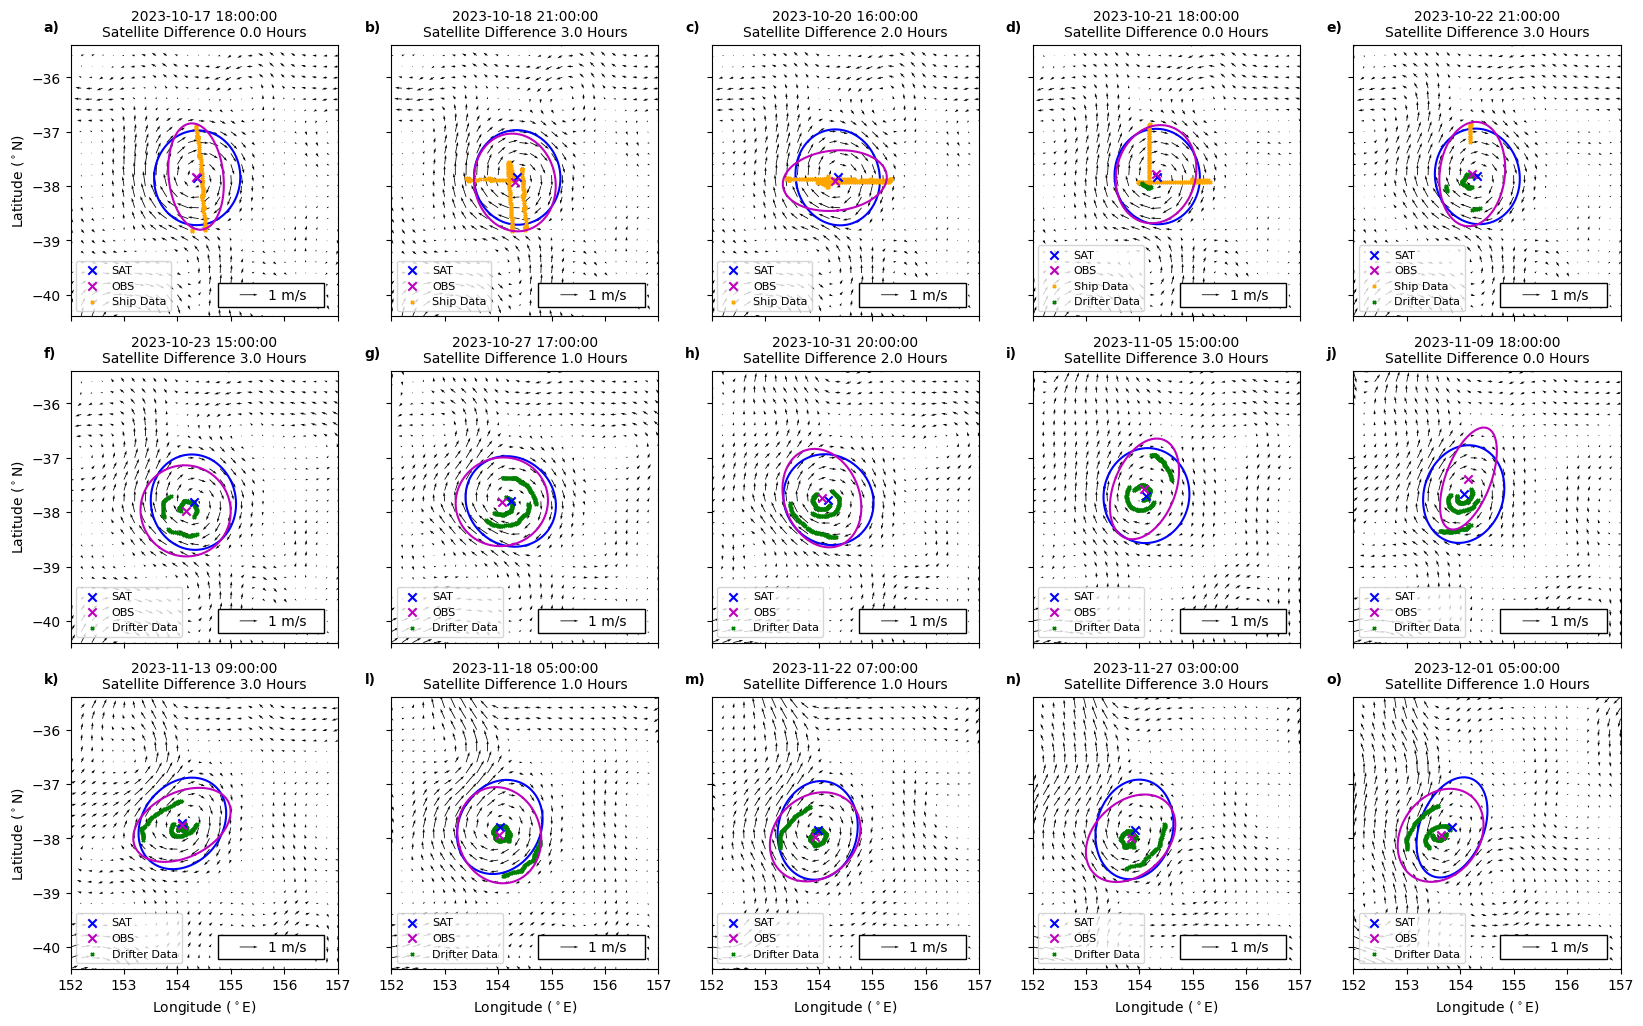

In [22]:
from matplotlib.patches import Rectangle

def int_to_excel(n):
    n += 1  # Convert to 1-indexed
    result = ""
    while n:
        n, remainder = divmod(n - 1, 26)
        result = chr(97 + remainder) + result  # 97 is ASCII for 'a'
    return result

rows, cols = 3, 5

spwidth = 4

fig, axs = plt.subplots(rows, cols, figsize=(spwidth*cols,spwidth*rows), sharey=True, sharex=True)

for k, time in enumerate(time_plots):

    ax = axs[k // cols, k % cols]

    df = df_trace_hrly[df_trace_hrly['Time']==time]

    x0, y0, w, Q, Rc, psi0, time, x0_obs, y0_obs, w_obs, Q_obs, Rc_obs, psi0_obs = (
        df['x0'].iloc[0],
        df['y0'].iloc[0],
        df['w'].iloc[0],
        df['Q'].iloc[0],
        df['Rc'].iloc[0],
        df['psi0'].iloc[0],
        df['Time'].iloc[0],
        df['x0_obs'].iloc[0],
        df['y0_obs'].iloc[0],
        df['w_obs'].iloc[0],
        df['Q_obs'].iloc[0],
        df['Rc_obs'].iloc[0],
        df['psi0_obs'].iloc[0],
    )
    

    closest_time = df_paper_plots[df_paper_plots['Time']==time]['Closest SAT Time'].iloc[0]
    
    error_hours = df_paper_plots[df_paper_plots['Time']==time]['SAT Time Difference'].iloc[0]
    
    ut, vt = dic_ssh_data[closest_time]['u'], dic_ssh_data[closest_time]['v']
    quiv = ax.quiver(lon_ssh, lat_ssh, ut.T, vt.T, width=0.003, scale=15)

    # ax.plot(df_ssh_trace['x0'], df_ssh_trace['y0'])#, linewidth=.5, alpha=.5)
    
    ax.scatter(x0, y0, marker='x', label='SAT', color='b', zorder=5)
    if not np.any(np.isnan(Q)):
        x_ell, y_ell = plot_ellipse(Q, center=(x0, y0), scale=1)
        ax.plot(x_ell, y_ell, color='b', zorder=2)
    else:
        df = df_trace_hrly[df_trace_hrly['Time']==closest_time]
        x0_sat_closest, y0_sat_closest, Q_sat_closest = df['x0'], df['y0'], df['Q'].iloc[0]
        x_ell, y_ell = plot_ellipse(Q_sat_closest, center=(x0_sat_closest, y0_sat_closest), scale=1)
        ax.plot(x_ell, y_ell, color='b', zorder=2)
        
    ax.scatter(x0_obs, y0_obs, marker='x', label='OBS', color='m', zorder=6)
    if not np.any(np.isnan(Q_obs)):
        x_ell, y_ell = plot_ellipse(Q_obs, center=(x0_obs, y0_obs), scale=1)
        ax.plot(x_ell, y_ell, color='m', zorder=6)


    xi, yi, ID = dic_obs_hrly[time]['xi'], dic_obs_hrly[time]['yi'], dic_obs_hrly[time]['ID']

    xi_ship, yi_ship = xi[np.isnan(ID)], yi[np.isnan(ID)]
    if len(xi_ship) > 0:
        ax.scatter(xi_ship, yi_ship, marker='x', color='orange', s=5, label='Ship Data', zorder=3)

    xi_drift, yi_drift = xi[~np.isnan(ID)], yi[~np.isnan(ID)]
    if len(xi_drift) > 0:
        ax.scatter(xi_drift, yi_drift, marker='x', color='g', s=5, label='Drifter Data', zorder=3)

    magnitude = 1
    x_pos, y_pos = 0.75, 0.08  
    box_width = 0.4 # Adjust width as needed
    box_height = 0.09  # Adjust height as needed
    rect = Rectangle((x_pos - box_width / 2, y_pos - box_height / 2), 
                           box_width, box_height, transform=ax.transAxes,
                           facecolor='white', edgecolor='black')
    ax.add_patch(rect)
    ax.quiverkey(quiv, X=x_pos-.05, Y=y_pos, U=magnitude,
                 label=f'{magnitude} m/s', labelpos='E')
    
    ax.legend(loc='lower left', fontsize=8)
    # ax.axis('equal')
    ax.set_xlim(lon_min_CE-2, lon_max_CE+2)
    ax.set_ylim(lat_min_CE-2, lat_max_CE+2)

    ax.text(-0.1, 1.05, int_to_excel(k)+')', transform=ax.transAxes, fontsize=10, fontweight='bold')
    ax.set_title(f'{time}\nSatellite Difference {error_hours} Hours', fontsize=10)

    if k % cols == 0:
        ax.set_ylabel(r'Latitude ($^\circ$N)')
    if k >= rows*cols - cols:
        ax.set_xlabel(r'Longitude ($^\circ$E)')



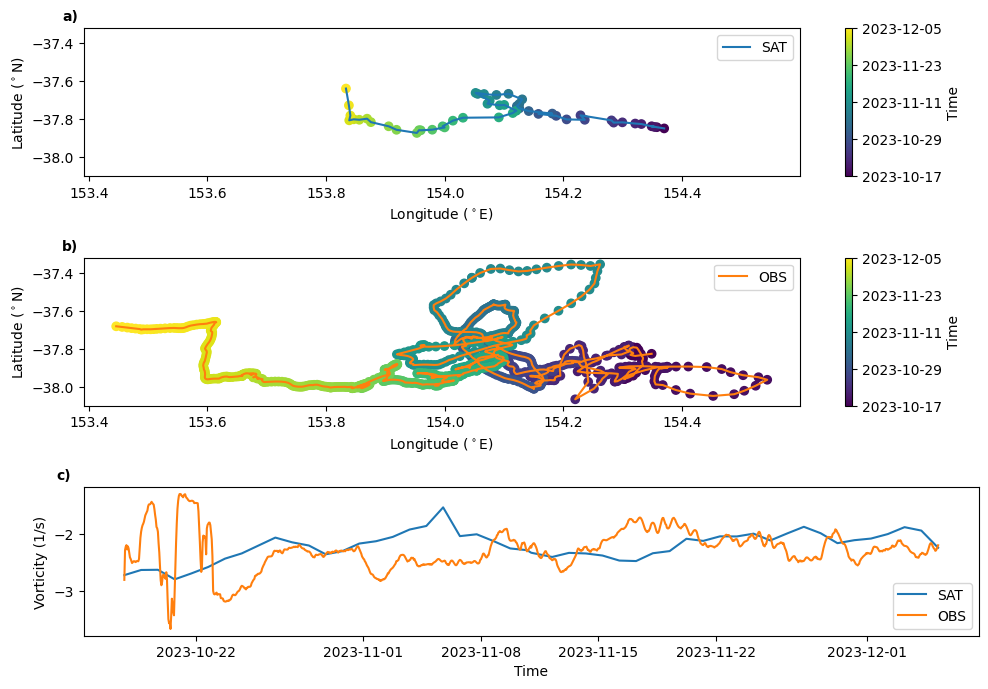

In [23]:
df1 = df_trace_hrly.copy().dropna()
df2 = df_trace_hrly.copy()

# start_plot_time = pd.Timestamp('2023-11-15 18:00:00')
# end_plot_time = pd.Timestamp('2023-12-01 06:00:00')

# df1 = df1[(df1['Time'] >= start_plot_time)&(df1['Time'] <= end_plot_time)]
# df2 = df2[(df2['Time'] >= start_plot_time)&(df2['Time'] <= end_plot_time)]

fig, axs = plt.subplots(3, 1, figsize=(10, 7))
tab10 = plt.get_cmap('tab10').colors

# Convert time to numeric (nanoseconds since epoch)
t1 = df1['Time'].astype('int64')
t2 = df2['Time'].astype('int64')
tmin, tmax = min(t1.min(), t2.min()), max(t1.max(), t2.max())
tick_locs = np.linspace(tmin, tmax, 5)
tick_labels = [pd.to_datetime(t).strftime('%Y-%m-%d') for t in tick_locs]

# Plot 1
sc1 = axs[0].scatter(df1['x0'], df1['y0'], c=t1, cmap='viridis', vmin=tmin, vmax=tmax)
axs[0].plot(df1['x0'], df1['y0'], color=tab10[0], linewidth=1.5, label='SAT')
cbar1 = fig.colorbar(sc1, ax=axs[0])
cbar1.set_ticks(tick_locs)
cbar1.set_ticklabels(tick_labels)
cbar1.set_label('Time')
# for (x0, y0, Q) in zip(df1['x0'], df1['y0'], df1['Q']):
#     x_ell, y_ell = plot_ellipse(Q, (x0,y0), scale=0.05)
#     axs[0].plot(x_ell, y_ell)
# axs[0].axis('equal')
axs[0].set_xlabel(r'Longitude ($^\circ$E)')
axs[0].set_ylabel(r'Latitude ($^\circ$N)')
axs[0].legend()
k = 0
axs[k].text(-0.03, 1.05, int_to_excel(k)+')', transform=axs[k].transAxes, fontsize=10, fontweight='bold')

# Plot 2
sc2 = axs[1].scatter(df2['x0_obs'], df2['y0_obs'], c=t2, cmap='viridis', vmin=tmin, vmax=tmax)
axs[1].plot(df2['x0_obs'], df2['y0_obs'], color=tab10[1], linewidth=1.5, label='OBS')
cbar2 = fig.colorbar(sc2, ax=axs[1])
cbar2.set_ticks(tick_locs)
cbar2.set_ticklabels(tick_labels)
cbar2.set_label('Time')
# axs[1].axis('equal')
axs[1].set_xlabel(r'Longitude ($^\circ$E)')
axs[1].set_ylabel(r'Latitude ($^\circ$N)')
axs[1].legend()
k += 1
axs[k].text(-0.03, 1.05, int_to_excel(k)+')', transform=axs[k].transAxes, fontsize=10, fontweight='bold')

# Plot 3
axs[2].plot(df1['Time'], df1['w'], label='SAT')
axs[2].plot(df2['Time'], df2['w_obs'], label='OBS')
axs[2].set_xlabel('Time')
axs[2].set_ylabel('Vorticity (1/s)')
axs[2].legend()
axs[2].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
k += 1
axs[k].text(-0.03, 1.05, int_to_excel(k)+')', transform=axs[k].transAxes, fontsize=10, fontweight='bold')

# Align x-limits for scatter plots
xmin = min(axs[0].get_xlim()[0], axs[1].get_xlim()[0])
xmax = max(axs[0].get_xlim()[1], axs[1].get_xlim()[1])
axs[0].set_xlim(xmin, xmax)
axs[1].set_xlim(xmin, xmax)

ymin = min(axs[0].get_ylim()[0], axs[1].get_ylim()[0])
ymax = max(axs[0].get_ylim()[1], axs[1].get_ylim()[1])
axs[0].set_ylim(ymin, ymax)
axs[1].set_ylim(ymin, ymax)

# axs[0].axis('equal')
# axs[1].axis('equal')

plt.tight_layout()
plt.show()


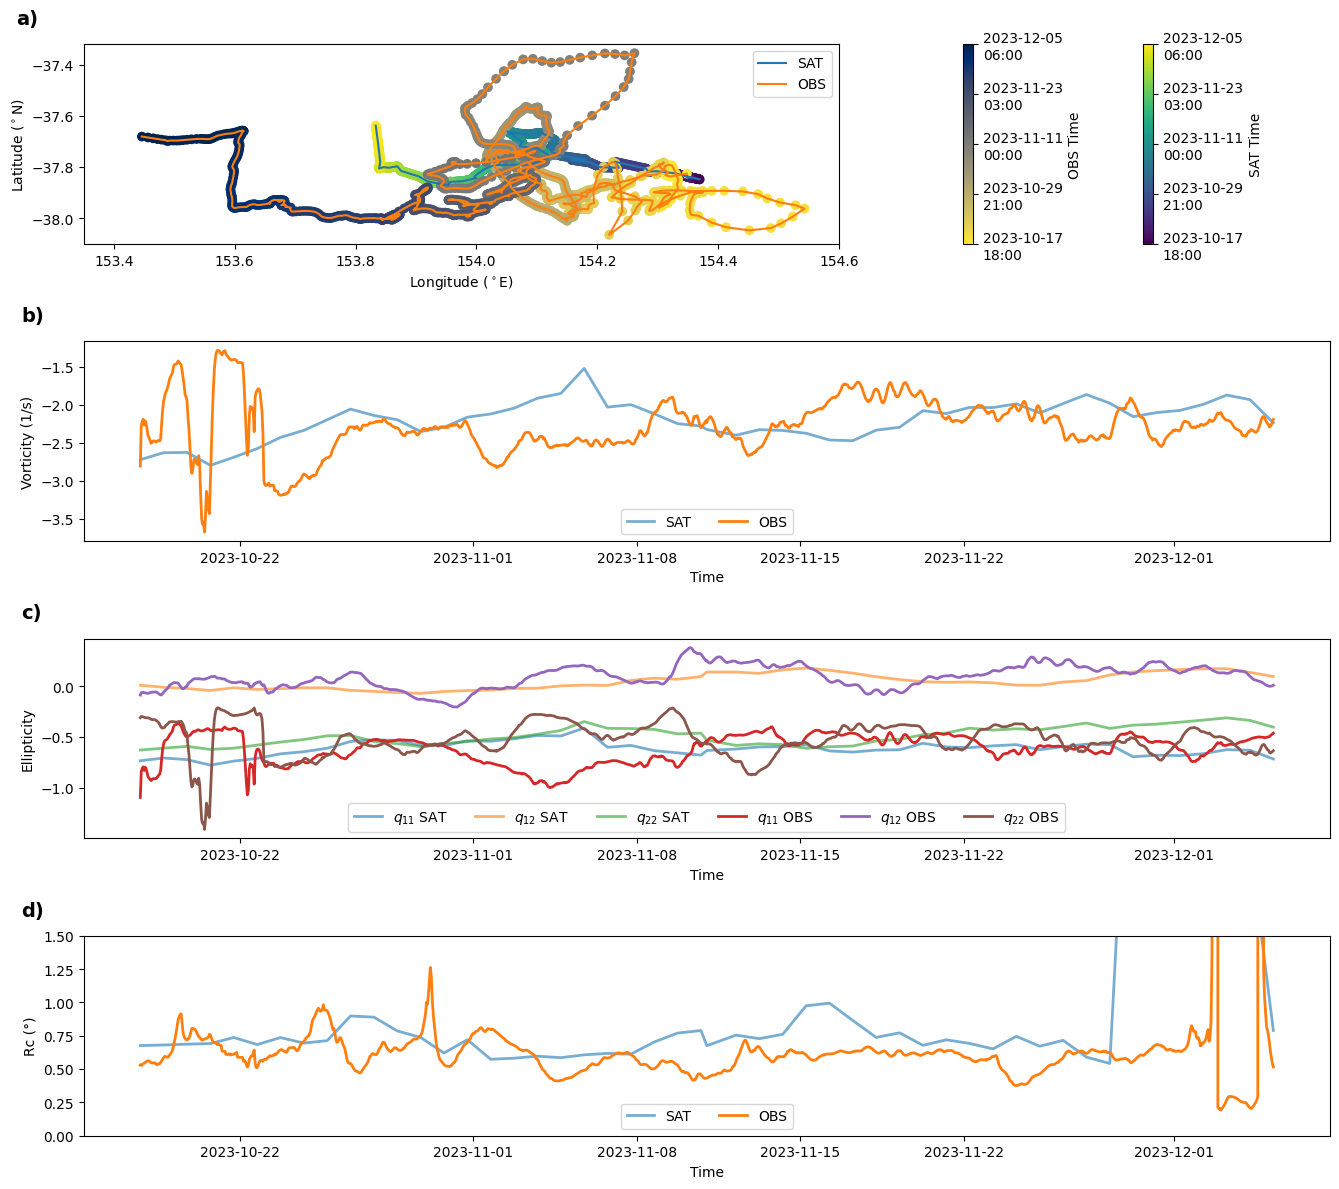

In [24]:
df1 = df_trace_hrly.copy().dropna()
df2 = df_trace_hrly.copy()

fig, axs = plt.subplots(4, 1, figsize=(13.5, 12))

# Plot SAT path
axs[0].plot(df_trace_hrly['x0'], df_trace_hrly['y0'], label='SAT')

# Plot OBS path
axs[0].plot(df_trace_hrly['x0_obs'], df_trace_hrly['y0_obs'], label='OBS')


# Time values
times = df_trace_hrly['Time']
timestamps = times.apply(lambda x: x.timestamp())

# SAT scatter + colorbar
norm_sat = plt.Normalize(timestamps.min(), timestamps.max())
sc1 = axs[0].scatter(df_trace_hrly['x0'], df_trace_hrly['y0'], c=timestamps, cmap='viridis', norm=norm_sat)
cbar1 = fig.colorbar(sc1, ax=axs[0], location='right', pad=0.02)
ticks = np.linspace(timestamps.min(), timestamps.max(), 5)
cbar1.set_ticks(ticks)
cbar1.set_ticklabels(pd.to_datetime(ticks, unit='s').strftime('%Y-%m-%d\n%H:%M'))
cbar1.set_label('SAT Time')

# OBS scatter + separate colorbar
sc2 = axs[0].scatter(df_trace_hrly['x0_obs'], df_trace_hrly['y0_obs'], c=timestamps, cmap='cividis_r', norm=norm_sat)
cbar2 = fig.colorbar(sc2, ax=axs[0], location='right', pad=0.12)
cbar2.set_ticks(ticks)
cbar2.set_ticklabels(pd.to_datetime(ticks, unit='s').strftime('%Y-%m-%d\n%H:%M'))
cbar2.set_label('OBS Time')

axs[0].set_xlabel(r'Longitude ($^\circ$E)')
axs[0].set_ylabel(r'Latitude ($^\circ$N)')

axs[0].set_xlim(153.35, 154.6)
axs[0].legend()
k = 0
axs[k].text(-0.09, 1.1, int_to_excel(k)+')', transform=axs[k].transAxes, fontsize=14, fontweight='bold')
k += 1

# Plot 2
axs[1].plot(df1['Time'], df1['w'], label='SAT', alpha=.6, linewidth=2)
axs[1].plot(df2['Time'], df2['w_obs'], label='OBS', linewidth=2)
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Vorticity (1/s)')
axs[1].legend(loc='lower center', ncol=2)
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
axs[k].text(-0.05, 1.1, int_to_excel(k)+')', transform=axs[k].transAxes, fontsize=14, fontweight='bold')
k += 1

# Plot 3
q11 = df1['Q'].apply(lambda Q: Q[0, 0])
q12 = df1['Q'].apply(lambda Q: Q[0, 1])
q22 = df1['Q'].apply(lambda Q: Q[1, 1])
q11_obs = df2['Q_obs'].apply(lambda Q: Q[0, 0])
q12_obs = df2['Q_obs'].apply(lambda Q: Q[0, 1])
q22_obs = df2['Q_obs'].apply(lambda Q: Q[1, 1])

axs[2].plot(df1['Time'], q11, label=r'$q_{11}$ SAT', alpha=.6, linewidth=2)
axs[2].plot(df1['Time'], q12, label=r'$q_{12}$ SAT', alpha=.6, linewidth=2)
axs[2].plot(df1['Time'], q22, label=r'$q_{22}$ SAT', alpha=.6, linewidth=2)

axs[2].plot(df2['Time'], q11_obs, label=r'$q_{11}$ OBS', linewidth=2)
axs[2].plot(df2['Time'], q12_obs, label=r'$q_{12}$ OBS', linewidth=2)
axs[2].plot(df2['Time'], q22_obs, label=r'$q_{22}$ OBS', linewidth=2)

axs[2].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
axs[2].legend(loc='lower center', ncol=6)
axs[2].set_xlabel('Time')
axs[2].set_ylabel('Ellipticity')
axs[k].text(-0.05, 1.1, int_to_excel(k)+')', transform=axs[k].transAxes, fontsize=14, fontweight='bold')
k += 1

# deg = -37.7
# length_lon = 111.32 * np.cos(np.radians(deg))
# mask = df2['Rc_obs'] < 4
axs[3].plot(df1['Time'], df1['Rc'], label='SAT', alpha=.6, linewidth=2)
axs[3].plot(df2['Time'], df2['Rc_obs'], label='OBS', linewidth=2)
axs[3].set_xlabel('Time')
axs[3].set_ylabel('Rc (°)')
axs[3].legend(loc='lower center', ncol=2)
axs[3].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
axs[3].set_ylim(0,1.5)
axs[k].text(-0.05, 1.1, int_to_excel(k)+')', transform=axs[k].transAxes, fontsize=14, fontweight='bold')
k += 1

# axs[4].plot(df1['Time'], df1['psi0'], label='SAT', alpha=.6)
# axs[4].plot(df2['Time'], df2['psi0_obs'], label='OBS')
# axs[4].set_xlabel('Time')
# axs[4].set_ylabel(r'$\psi_0$')
# axs[4].legend()
# axs[4].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
# # axs[4].set_ylim(None,100)

plt.tight_layout()
plt.show()


### MOCA Application

In [25]:
def project_sadcp_data(x, y, u, v):

    num_points = len(x)

    df = pd.DataFrame({'x': x, 'y': y, 'u': u, 'v': v})
    df = df.sort_values(by='x').reset_index(drop=True)
    x, y, u, v = np.array(df['x']), np.array(df['y']), np.array(df['u']), np.array(df['v'])

    # Fit a best-fit line (y = m*x + c) using linear regression.
    A = np.vstack([x, np.ones(len(x))]).T
    m, _ = np.linalg.lstsq(A, y, rcond=None)[0]
    # Create a unit direction vector along the best-fit line.
    direction = np.array([1, m])
    direction = direction / np.linalg.norm(direction)
    # Project each (x, y) point onto the line using the first point as reference.
    p0 = np.array([x[0], y[0]])
    points = np.column_stack((x, y))
    projections = np.dot(points - p0, direction)
    # Sort projections and corresponding velocities.
    sort_idx = np.argsort(projections)
    proj_sorted = projections[sort_idx]
    u_sorted = u[sort_idx]
    v_sorted = v[sort_idx]
    # Interpolate the velocity components on evenly spaced positions.
    new_distances = np.linspace(proj_sorted.min(), proj_sorted.max(), num_points)
    new_u = np.interp(new_distances, proj_sorted, u_sorted)
    new_v = np.interp(new_distances, proj_sorted, v_sorted)
    # Calculate new (x, y) points along the line.
    new_points = p0 + np.outer(new_distances, direction)
    # Create and return the output dataframe.
    x, y = new_points[:, 0], new_points[:, 1]

    cos_theta = 1 / np.sqrt(1+m**2)
    sin_theta = m / np.sqrt(1+m**2)
    V_N = -new_u * sin_theta + new_v * cos_theta
    V_T = new_v * sin_theta + new_u * cos_theta
        
    df_projected = pd.DataFrame({
        'x': x,
        'y': y,
        'u': new_u,
        'v': new_v,
        'V_N': V_N,
        'V_T': V_T,
        # 'l': new_distances
    })

    df_projected = df_projected.sort_values(by='x').reset_index(drop=True)

    df_projected['l'] = np.hypot(df_projected['x']-df_projected['x'].iloc[0], df_projected['y']-df_projected['y'].iloc[0])

    return df_projected, m

def translate_MOCA(x_l_start, y_l_start, m, l0, r0):

    x0 = (l0-r0*m)/np.sqrt(1+m**2) + x_l_start
    y0 = (l0*m+r0)/np.sqrt(1+m**2) + y_l_start
    
    return x0, y0

0.48399324436283014 0.2553286900327619
0.936652684004812 0.8888036732441144
40.67242049189922 1335.2528989760049
0.4238175961645682 0.1858817662291366
0.6354004326657973 0.4082288532571404
1.4027442658453535 1.9388745188627488


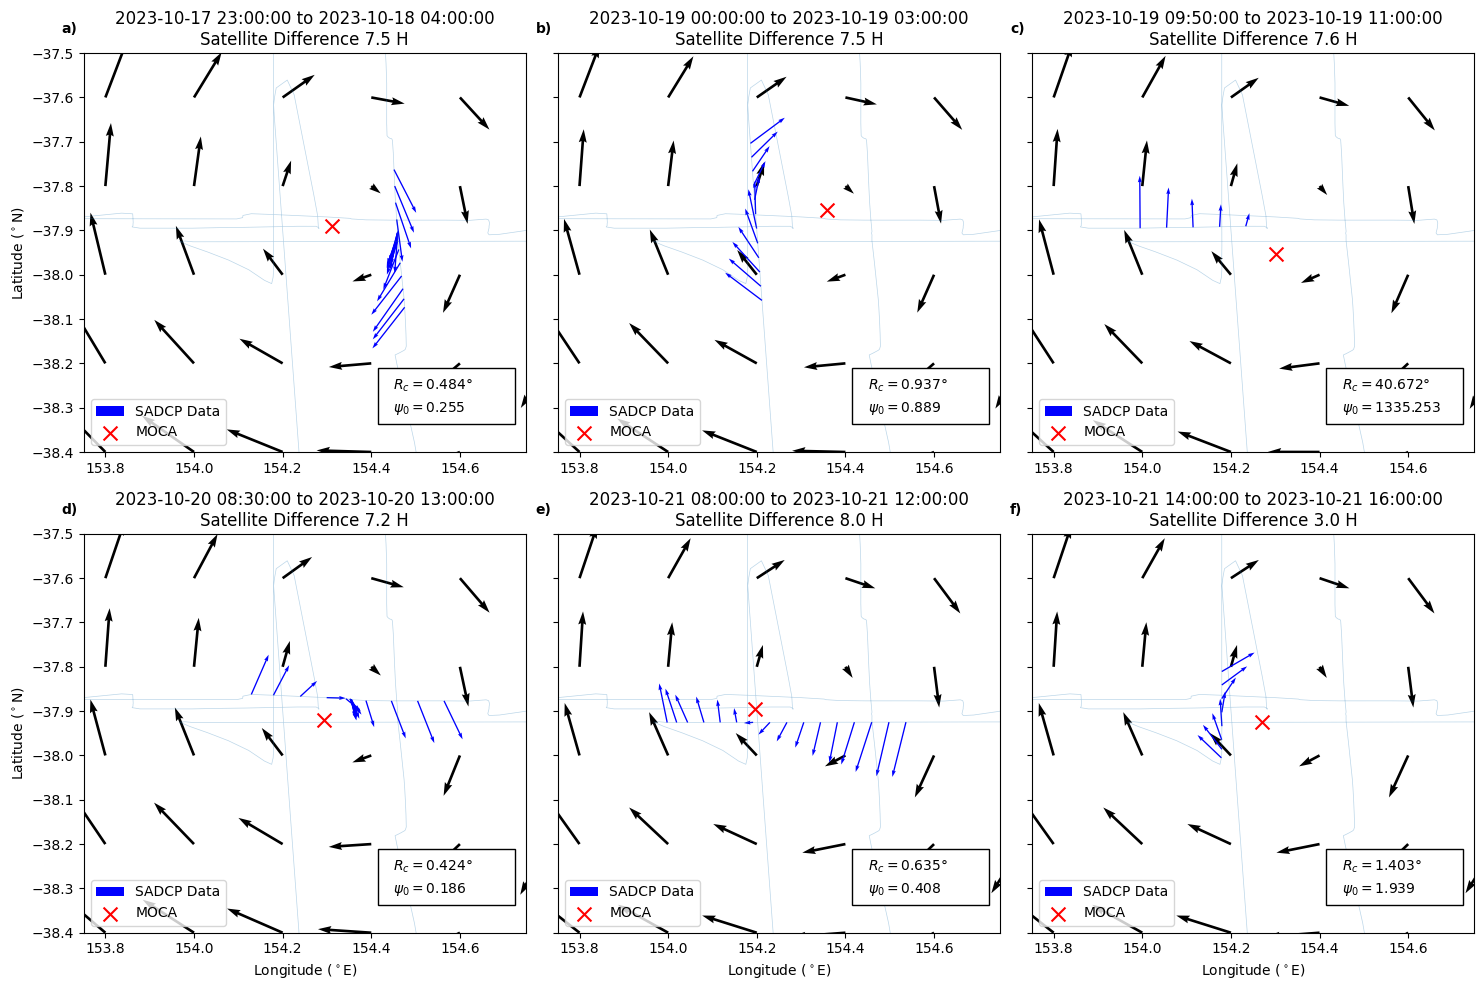

In [26]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10), sharey=True)

t1s = [
    pd.Timestamp('2023-10-17 23:00:00'),
    pd.Timestamp('2023-10-19 00:00:00'),
    pd.Timestamp('2023-10-19 09:50:00'),
    pd.Timestamp('2023-10-20 08:30:00'),
    pd.Timestamp('2023-10-21 08:00:00'),
    pd.Timestamp('2023-10-21 14:00:00'),

]

t2s = [
    pd.Timestamp('2023-10-18 04:00:00'),
    pd.Timestamp('2023-10-19 03:00:00'),
    pd.Timestamp('2023-10-19 11:00:00'),
    pd.Timestamp('2023-10-20 13:00:00'),
    pd.Timestamp('2023-10-21 12:00:00'),
    pd.Timestamp('2023-10-21 16:00:00'),
   
]

scale = 5
width = .003
for k, (t1, t2) in enumerate(zip(t1s, t2s)):
    ax = axs[k // 3, k % 3]
    
    target_time = t1 + (t2 - t1) / 2
    reference_times = list(dic_ssh_data.keys())
    closest_time = min(reference_times, key=lambda t: abs(t - target_time))
    error_hours = abs((closest_time - target_time).total_seconds()) / 3600
    df_interval = df_sadcp[(df_sadcp['Time'] >= t1) & (df_sadcp['Time'] <= t2)].copy()
    ut, vt = dic_ssh_data[closest_time]['u'], dic_ssh_data[closest_time]['v']
    ax.quiver(lon_ssh, lat_ssh, ut.T, vt.T, width=2*width, scale=scale, zorder=0)
    ax.plot(df_sadcp['Lon'], df_sadcp['Lat'], alpha=0.3, linewidth=0.5)
    ax.quiver(df_interval['Lon'], df_interval['Lat'], df_interval['u'], df_interval['v'],
                  width=width, scale=scale, color='b', label='SADCP Data')
    df_MOCA_prep, m = project_sadcp_data(np.array(df_interval['Lon']),
                                          np.array(df_interval['Lat']),
                                          np.array(df_interval['u']),
                                          np.array(df_interval['v']))
    # ax.quiver(df_MOCA_prep['x'], df_MOCA_prep['y'], df_MOCA_prep['u'], df_MOCA_prep['v'],
                  # width=width, scale=scale, color='m', alpha=.5, label='Linear Projection of Velocities')
    l0, r0, w, Q, Rc, psi0 = moca(df_MOCA_prep['l'], df_MOCA_prep['V_T'], df_MOCA_prep['V_N'])
    print(Rc, psi0)
        
    x_l_start = df_MOCA_prep.iloc[0]['x']
    y_l_start = df_MOCA_prep.iloc[0]['y']
    x0, y0 = translate_MOCA(x_l_start, y_l_start, m, l0, r0)

    if k == 1:
        x0p, y0p, wp, Qp, Rcp, psi0p = x0, y0, w, Q, Rc, psi0
        lonp = lon_ssh
        latp = lat_ssh
        up = ut
        vp = vt
            
    ax.scatter(x0, y0, marker='x', color='r', zorder=5, label='MOCA', s=100)
    ax.axis('equal')
    ax.set_xlim(153.5, 155)
    ax.set_ylim(-38.4, -37.5)
    ax.set_title(f'{t1} to {t2}\nSatellite Difference {error_hours:.1f} H')
    if k >= 3:
        ax.set_xlabel(r'Longitude ($^\circ$E)')
    if k % 3 == 0:
        ax.set_ylabel(r'Latitude ($^\circ$N)')
    ax.legend()
    ax.text(-.05, 1.05, int_to_excel(k)+')', transform=ax.transAxes, fontsize=10, fontweight='bold')



    x_pos, y_pos = 0.82, 0.14
    box_width = 0.31  # Adjust width as needed
    box_height = 0.14 #0.07  # Adjust height as needed
    rect = Rectangle((x_pos - box_width / 2, y_pos - box_height / 2), 
                           box_width, box_height, transform=ax.transAxes,
                           facecolor='white', edgecolor='black', zorder=10)
    ax.add_patch(rect)

    ax.text(154.45, -38.26, fr'$R_c=${Rc:.3f}°', zorder=10)
    ax.text(154.45, -38.31, fr'$\psi_0=${psi0:.3f}', zorder=10)

# axs[0].set_ylabel(r'Latitude ($^\circ$N)')
plt.tight_layout()
plt.show()


#### Remodelling

In [27]:
x_domain = np.linspace(lon_min_CE-2, lon_max_CE+2, 21)
y_domain = np.linspace(lat_min_CE-2, lat_max_CE+2, 21)
X_domain, Y_domain = np.meshgrid(x_domain, y_domain)


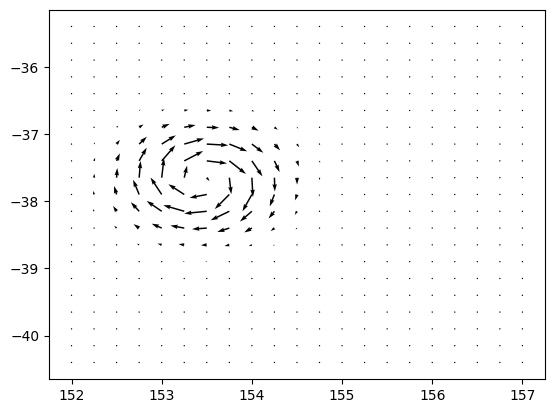

In [28]:

for (x0t, y0t, Qt, Rct, psi0t) in zip(df_trace_hrly['x0_obs'], df_trace_hrly['y0_obs'], df_trace_hrly['Q_obs'], df_trace_hrly['Rc_obs'], df_trace_hrly['psi0_obs']):
    

    u, v, X, Y = gaussian_vel_reconstruction(x0t, y0t, Qt[0,0], Qt[0,1], Qt[1,1], Rct, psi0t, X_domain, Y_domain)
    
plt.quiver(X, Y, u, v, scale=10, width=.003)

822 frame(s) have no matching 'Closest SAT Time' in df_paper_plots.


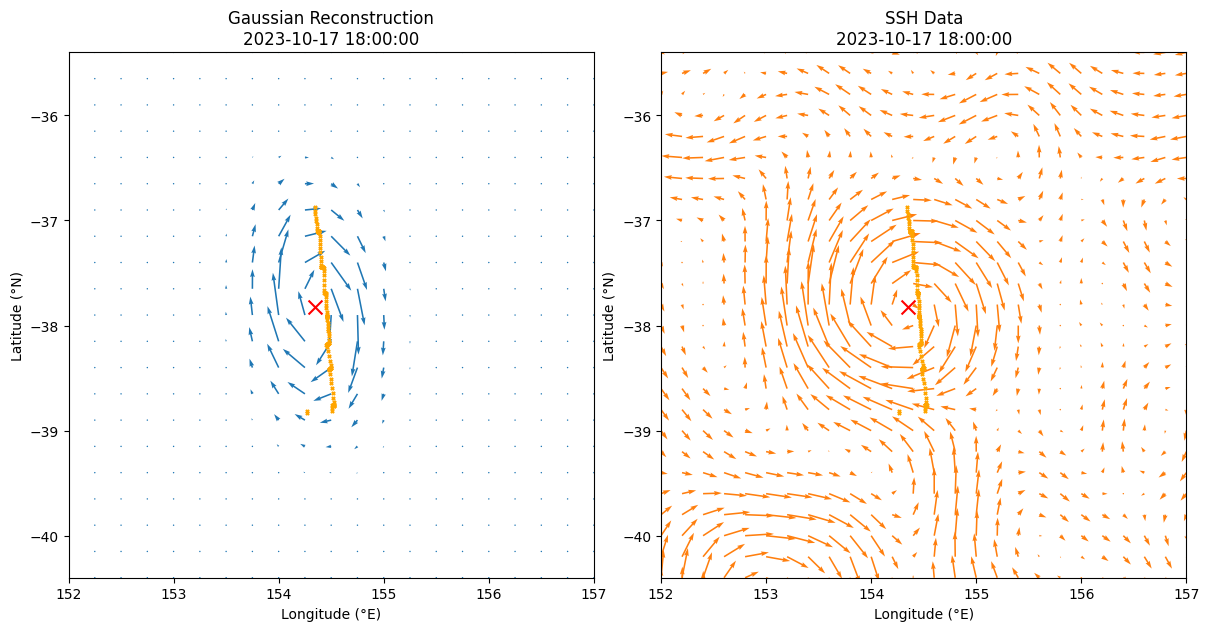

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd

# ────────────────────────────────────────────────────────────────
# Step 1: Merge df_trace_hrly & df_paper_plots on "Time"
# ────────────────────────────────────────────────────────────────
df_merge = (
    df_trace_hrly
    .loc[:, ['Time', 'x0_obs', 'y0_obs', 'Q_obs', 'Rc_obs', 'psi0_obs']]
    .merge(
        df_paper_plots[['Time', 'Closest SAT Time']],
        on='Time',
        how='left'       # left-join: missing times → NaN in 'Closest SAT Time'
    )
)

n_missing = df_merge['Closest SAT Time'].isna().sum()
print(f"{n_missing} frame(s) have no matching 'Closest SAT Time' in df_paper_plots.")


# ────────────────────────────────────────────────────────────────
# Step 2: Create figure & all “persistent” artists
# ────────────────────────────────────────────────────────────────
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# --- SUBPLOT 1: Gaussian‐reconstruction quiver on (X_domain, Y_domain)
u0 = np.zeros_like(X_domain)
v0 = np.zeros_like(Y_domain)
quiver1 = ax1.quiver(
    X_domain, Y_domain, u0, v0,
    scale=10, width=0.003,
    color='C0'
)
ax1.set_title("Gaussian Reconstruction")
ax1.set_aspect("equal")
ax1.set_xlim(X_domain.min(), X_domain.max())
ax1.set_ylim(Y_domain.min(), Y_domain.max())

# Persistent scatter for the Gaussian‐center marker (single red “x”)
scatter_gauss_center = ax1.scatter([], [], marker='x', color='r', s=100, zorder=3)

# --- SUBPLOT 2: SSH quiver on (lon_ssh, lat_ssh)
u0_ssh = np.zeros_like(lon_ssh)
v0_ssh = np.zeros_like(lat_ssh)
quiver2 = ax2.quiver(
    lon_ssh, lat_ssh, u0_ssh, v0_ssh,
    scale=10, width=0.003,
    color='C1'
)
ax2.set_title("SSH Data")
ax2.set_aspect("equal")
ax2.set_xlim(lon_min_CE - 2, lon_max_CE + 2)
ax2.set_ylim(lat_min_CE - 2, lat_max_CE + 2)

# Persistent scatter for the SSH‐center marker (single red “x”)
scatter_ssh_center = ax2.scatter([], [], marker='x', color='r', s=100, zorder=3)

# --- Now, create persistent scatters for Ship & Drifter data on both subplots:
#     These will be updated each frame, so they never “pile up.”
ship_scatter1   = ax1.scatter([], [], marker='x', color='orange', s=5, zorder=2)
drifter_scatter1 = ax1.scatter([], [], marker='x', color='g', s=5, zorder=2)

ship_scatter2   = ax2.scatter([], [], marker='x', color='orange', s=5, zorder=2)
drifter_scatter2 = ax2.scatter([], [], marker='x', color='g', s=5, zorder=2)

plt.tight_layout()


# ────────────────────────────────────────────────────────────────
# Step 2.5: Prepare a “previous SSH” container for ut, vt
# ────────────────────────────────────────────────────────────────
prev_ssh = {
    'u': u0_ssh.copy(),
    'v': v0_ssh.copy()
}


# ────────────────────────────────────────────────────────────────
# Step 3: Define update(frame) to modify all existing artists
# ────────────────────────────────────────────────────────────────
def update(frame):
    # 3.1 Extract row from merged DataFrame
    row = df_merge.iloc[frame]
    x0t          = row['x0_obs']
    y0t          = row['y0_obs']
    Qt           = row['Q_obs']            # 2×2 numpy array
    Rct          = row['Rc_obs']
    psi0         = row['psi0_obs']
    closest_time = row['Closest SAT Time'] # might be NaN
    this_time    = row['Time']

    # 3.2 Update Gaussian‐center and SSH‐center markers
    scatter_gauss_center.set_offsets([[x0t, y0t]])
    scatter_ssh_center .set_offsets([[x0t, y0t]])

    # 3.3 Decide which (ut, vt) to use for the SSH quiver
    if pd.notna(closest_time):
        # If we have a valid SAT match, pull fresh u/v and store them
        ut = dic_ssh_data[closest_time]['u']
        vt = dic_ssh_data[closest_time]['v']
        prev_ssh['u'] = ut.copy()
        prev_ssh['v'] = vt.copy()
    else:
        # Otherwise, keep the previous values
        ut = prev_ssh['u']
        vt = prev_ssh['v']

    # Update the SSH quiver (transpose if your ut/vt are [lat, lon])
    quiver2.set_UVC(ut.T, vt.T)

    # 3.4 Compute Gaussian‐reconstruction u/v on (X_domain, Y_domain)
    Q00, Q01 = Qt[0, 0], Qt[0, 1]
    Q11      = Qt[1, 1]
    u_gauss, v_gauss, Xg, Yg = gaussian_vel_reconstruction(
        x0t, y0t,
        Q00, Q01, Q11,
        Rct, psi0,
        X_domain, Y_domain
    )
    quiver1.set_UVC(u_gauss, v_gauss)

    # 3.5 Ship/Drifter Data: pull xi, yi, ID from dic_obs_hrly for this_time
    xi = dic_obs_hrly[this_time]['xi']
    yi = dic_obs_hrly[this_time]['yi']
    ID = dic_obs_hrly[this_time]['ID']

    # Split into Ship (ID is NaN) and Drifter (ID is not NaN)
    xi_ship  = xi[np.isnan(ID)]
    yi_ship  = yi[np.isnan(ID)]
    xi_drift = xi[~np.isnan(ID)]
    yi_drift = yi[~np.isnan(ID)]

    # Update the ship & drifter scatters on subplot 1
    if len(xi_ship) > 0:
        ship_scatter1.set_offsets(np.column_stack([xi_ship, yi_ship]))
    else:
        ship_scatter1.set_offsets(np.empty((0, 2)))  # no points

    if len(xi_drift) > 0:
        drifter_scatter1.set_offsets(np.column_stack([xi_drift, yi_drift]))
    else:
        drifter_scatter1.set_offsets(np.empty((0, 2)))

    # Update the ship & drifter scatters on subplot 2
    if len(xi_ship) > 0:
        ship_scatter2.set_offsets(np.column_stack([xi_ship, yi_ship]))
    else:
        ship_scatter2.set_offsets(np.empty((0, 2)))

    if len(xi_drift) > 0:
        drifter_scatter2.set_offsets(np.column_stack([xi_drift, yi_drift]))
    else:
        drifter_scatter2.set_offsets(np.empty((0, 2)))

    # 3.6 Update subplot titles and axis labels
    ax1.set_title(f"Gaussian Reconstruction\n{this_time}")
    ax1.set_xlabel("Longitude (°E)")
    ax1.set_ylabel("Latitude (°N)")

    # ax2.set_title(f"SSH Data\n{'' if pd.isna(closest_time) else closest_time}")
    ax2.set_title(f"SSH Data\n{this_time}")
    ax2.set_xlabel("Longitude (°E)")
    ax2.set_ylabel("Latitude (°N)")

    # 3.7 Return all artists that changed this frame:
    return (
        quiver1,
        quiver2,
        scatter_gauss_center,
        scatter_ssh_center,
        ship_scatter1,
        drifter_scatter1,
        ship_scatter2,
        drifter_scatter2,
    )


# ────────────────────────────────────────────────────────────────
# Step 4: Build & display the animation
# ────────────────────────────────────────────────────────────────
ani = animation.FuncAnimation(
    fig,
    update,
    frames=len(df_merge),
    interval=200,     # milliseconds between frames
    blit=True
)

plt.show()


In [30]:
ani.save('eddy_quiver.gif',
         writer='pillow',
         fps=100) 
